In [1]:
# Imports
from src.data_retrieval import init_osm
from src.preprocessing import load_roads, load_railways, load_water_polygons, get_local_crs, reproject_all, build_water_edges, prepare_water_geometries
from src.prepare_pois import load_pois_with_green, prepare_pois, assign_pois_to_blocks
from src.process_blocks import construct_blocks, filter_water_blocks, filter_small_blocks, filter_irregular_blocks, remove_false_water_blocks
from src.plotting import plot_block_graph, plot_blocks_with_pois, plot_ge_heatmap, plot_variance, plot_largest_component
from src.construct_graph import build_block_graph
from src.network_analysis import get_largest_component, prepare_category_dicts, compute_generalized_euclidean_matrix, load_Q, compute_and_store_Q, compute_variance, compute_z_scores
from src.network_distance import ge, _ge_Q, variance, _resistance, calculate_spl


In [2]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

Setup

In [3]:
CITY_NAME = "Copenhagen"
# CITY_NAME = "Gdansk"

# Initialize OSM
osm, boundary = init_osm(CITY_NAME)

Downloaded Protobuf data 'Copenhagen.osm.pbf' (48.03 MB) to:
'/home/zuziaderylo/masters_thesis/data/raw/Copenhagen.osm.pbf'


In [4]:
roads = load_roads(osm)
railways = load_railways(osm)
water_polygons = load_water_polygons(osm)
pois = load_pois_with_green(osm)

/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


Loaded 30016 regular POIs
Loaded 981 green-space features
Total combined POIs: 30997


In [5]:
# Compute city-local UTM projection
local_epsg = get_local_crs(boundary)
print(f"Using local CRS: EPSG:{local_epsg}")

# Reproject all at once
layers = {
    "boundary": boundary,
    "roads": roads,
    "railways": railways,
    "water_polygons": water_polygons,
    "pois": pois
}
layers = reproject_all(layers, local_epsg)

# Unpack
boundary = layers["boundary"]
roads = layers["roads"]
railways = layers["railways"]
water_polygons = layers["water_polygons"]
pois = layers["pois"]

Using local CRS: EPSG:32633


In [6]:
print(boundary.crs)

EPSG:32633


In [7]:
# Build water edges after reprojection
water_edges = build_water_edges(layers["water_polygons"])

# Change water geometries
water_polygons = prepare_water_geometries(water_polygons)

In [8]:
# Prepare pois
pois = prepare_pois(pois=pois)

Number of POIs after cleaning: 30916
Assigned categories for 23284 POIs (75.3% coverage)
Number of POIs after categorization: 30916


In [9]:
len(roads)

77294

In [10]:
len(water_edges)

3075

In [11]:
len(railways)

4598

In [12]:
# Create initial blocks
initial_blocks = construct_blocks(roads, railways, water_edges)

len(initial_blocks)

8479

In [13]:
# Process blocks
blocks_no_water = filter_water_blocks(initial_blocks, water_polygons)
blocks_no_small = filter_small_blocks(blocks_no_water)
blocks_cleaned, suspicious = remove_false_water_blocks(blocks_no_small, area_quantile=0.999, compactness_quantile=0.03)
blocks_no_irregular = filter_irregular_blocks(blocks_cleaned)

blocks = blocks_no_irregular

print(len(blocks))


Iteration 1:
Threshold = 543.43 m²
Small blocks found = 1976
 Merged 1976 small blocks.
 Remaining blocks = 5928

Iteration 2:
Threshold = 543.43 m²
Small blocks found = 0
No small blocks left
Removed 2 suspected false-water blocks (area>100%, compactness<3%).


/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/zuziaderylo/anaconda3/envs/masters/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be s

5335


In [14]:
blocks_with_pois = assign_pois_to_blocks(pois, blocks)

blocks = blocks_with_pois

POIs assigned to 2825 blocks (out of 5335)


In [15]:
plot_blocks_with_pois(blocks=blocks_with_pois, city_name=CITY_NAME, title="block-level POI density", save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

In [16]:
blocks["area"] = blocks.geometry.area
blocks[["area"]].to_csv("block_sizes_copenhagen.csv", index=False)

In [17]:
avg_block_area = blocks["area"].mean()
print("Average block area:", round(avg_block_area, 2))

Average block area: 16474.14


In [18]:
block_area_var = blocks["area"].var()
print("Block area variance:", round(block_area_var, 2))

Block area variance: 3072154599.42


In [19]:
q25 = blocks["area"].quantile(0.25)
q75 = blocks["area"].quantile(0.75)

area_total = blocks["area"].sum()
area_small = blocks.loc[blocks["area"] <= q25, "area"].sum() / area_total
area_large = blocks.loc[blocks["area"] >= q75, "area"].sum() / area_total

print(f"Area share of small blocks (<25th): {area_small:.2%}")
print(f"Area share of large blocks (>75th): {area_large:.2%}")

Area share of small blocks (<25th): 1.77%
Area share of large blocks (>75th): 75.98%


In [20]:
blocks["perimeter"] = blocks.geometry.length
blocks["compactness"] = (4 * np.pi * blocks["area"]) / (blocks["perimeter"] ** 2)
avg_compactness = blocks["compactness"].mean()
print("Average compactness:", round(avg_compactness, 3))

Average compactness: 0.53


In [21]:
n_pois = len(pois)
pois_per_block = n_pois / len(blocks)
print(f"Number of POIs: {n_pois}")
print(f"POIs per block: {pois_per_block:.2f}")

Number of POIs: 30916
POIs per block: 5.79


Graph

In [22]:
# Build graph from blocks with POIs
G = build_block_graph(blocks_with_pois)

Graph constructed: 5335 nodes, 15786 edges


In [23]:
plot_block_graph(G, blocks, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

In [24]:
# Select largest connected component
G_largest = get_largest_component(G)

Graph has 82 components.
Largest component: 5183 nodes, 15694 edges.


In [25]:
avg_degree = sum(dict(G_largest.degree()).values()) / G_largest.number_of_nodes()
print("Average degree:", round(avg_degree, 3))

Average degree: 6.056


In [26]:
density = nx.density(G_largest)
print("Density:", round(density, 5))

Density: 0.00117


Checking number of components and why they are not connected

In [27]:
plot_largest_component(blocks, G, CITY_NAME, title="largest connected component", save_path="report/figures")

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [28]:
# Compute Q
Q = compute_and_store_Q(G_largest, CITY_NAME)

In [29]:
# Load 
G_largest, Q = load_Q(CITY_NAME)

Graph nodes: 5183, Q shape: (5183, 5183)


In [30]:
# Prepare category dictionaries
category_counts = blocks_with_pois.attrs["category_counts"]
category_dicts_largest = prepare_category_dicts(category_counts, G_largest)

In [31]:
# Compute GE matrix
df_ge = compute_generalized_euclidean_matrix(G_largest, category_dicts_largest, ge=ge, Q_func=lambda G: Q)

df_ge.to_csv("data/processed/Copenhagen_results_GE.csv", index=False)


In [32]:
df_ge.shape

(9, 9)

In [33]:
df_ge.values.mean()

0.07440758475816003

In [34]:
print(len(pois))

30916


In [35]:
# Plot heatmap
plot_ge_heatmap(df_ge, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Copenhagen Generalized Euclidean Distance between Amenity Categories'}>)

In [36]:
# Precompute resistance once
def precompute_resistance(G_largest):
    resistance_matrix = _resistance(G_largest)

    return resistance_matrix

In [37]:
resistance_matrix = precompute_resistance(G_largest)

In [38]:
# Compute variance for each category (using precomputed resistance matrix)
variance_categories = compute_variance(category_dicts_largest, G_largest, resistance_matrix)

                          variance
food                      0.310291
education                 0.369498
green_spaces              0.533707
infrastructure_transport  0.405366
other_daily_utilities     0.393534
retail                    0.276325
culture_leisure           0.300649
public_services           0.323928
healthcare                0.371608


In [39]:
plot_variance(variance_categories, city_name=CITY_NAME, save_path="report/figures")

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Copenhagen Variance per Amenity Category'}, ylabel='Variance'>)

In [40]:
# Generate distribution of variances from shuffled pois
def shuffled_variances(v_dict, G, resistance_matrix, n_iter=1000):
    # Store variance values from each shuffle
    results = []

    #Extract node IDs and their associated values separately
    nodes = list(v_dict.keys()) # stay fix
    values = list(v_dict.values()) # to shuffle

    # Perform random shuffling multiple times
    for _ in range(n_iter):
        # Shuffle POI values
        random.shuffle(values)

        # Reassign shuffled values to nodes
        shuffled_v = dict(zip(nodes, values))

        # Compute variance for this shuffled configuration
        var_random = variance(shuffled_v, G, shortest_path_lengths=resistance_matrix, kernel="resistance")
        
        # Store
        results.append(var_random)

    return np.array(results)


In [41]:
# For each POI category:
# 1. Compute real variance
# 2. Generate random variance distribution
# 3. Compute z-score
def compute_z_scores(category_dicts, G, resistance_matrix, n_iter=1000):
    # Store results for all categories
    random_stats = {}

    # Iterate over each POI category
    for category, v_dict in category_dicts.items():
        # Compute real variance
        real_var = variance(v_dict, G,
                            shortest_path_lengths=resistance_matrix,
                            kernel="resistance")
        
        # Generate dstribution from shuffled data
        rand_vars = shuffled_variances(v_dict, G, resistance_matrix, n_iter)

        # Compute mean and standard deviation
        mean_rand = np.mean(rand_vars)
        std_rand = np.std(rand_vars)

        # Compute z-score
        # Positive z => more spread out than random
        # Negative z => more clustered than random
        z = (real_var - mean_rand) / std_rand if std_rand > 0 else np.nan

        # Store all results for this category: variance, average of random variances, standard deviation if random variances, normalized difference
        random_stats[category] = {
            "real_var": real_var,
            "mean_rand": mean_rand,
            "std_rand": std_rand,
            "z_score": z,
            "rand_vars": rand_vars
        }

    # Return as dataframe
    return pd.DataFrame.from_dict(random_stats, orient="index")


In [42]:
df_z = compute_z_scores(category_dicts_largest, G_largest, resistance_matrix, n_iter=1000)

In [43]:
# Store after computing df_z
SAVE_DIR = "data/processed"
df_z.to_csv(f"{SAVE_DIR}/{CITY_NAME}_results_z_scores.csv", index=True)

In [44]:
order = [
    "food",
    "retail",
    "education",
    "healthcare",
    "infrastructure_transport",
    "culture_leisure",
    "green_spaces",
    "public_services",
    "other_daily_utilities",
]

pretty_labels = [
    "Food",
    "Retail",
    "Education",
    "Healthcare",
    "Infrastructure & transport",
    "Culture & leisure",
    "Green spaces",
    "Public services",
    "Other daily utilities",
]

label_map = dict(zip(order, pretty_labels))


In [47]:
import os
import seaborn as sns

def plot_variance_distribution_from_results(category, df_z, label_map, CITY_NAME):

    # --- Create save directory ---
    save_root = "report/figures"
    save_dir = os.path.join(save_root, "zscores")
    os.makedirs(save_dir, exist_ok=True)

    rand_vars = df_z.loc[category, "rand_vars"]
    real_var  = df_z.loc[category, "real_var"]
    mean_rand = df_z.loc[category, "mean_rand"]
    std_rand  = df_z.loc[category, "std_rand"]
    z         = df_z.loc[category, "z_score"]

    pretty = label_map.get(category, category)

    # KDE peak calc
    plt.figure(figsize=(8, 5))
    tmp = sns.kdeplot(rand_vars, bw_adjust=1, color="black")
    x_vals = tmp.get_lines()[0].get_xdata()
    y_vals = tmp.get_lines()[0].get_ydata()
    plt.clf()

    plt.figure(figsize=(10, 5))

    sns.histplot(rand_vars, bins=30, stat='density',
                 color="lightgray", edgecolor=None, alpha=0.6)

    sns.kdeplot(rand_vars, bw_adjust=1, color="dimgray",
                linewidth=2, alpha=0.6, label="Distribution")

    plt.axvline(real_var, color="red", linestyle="--", linewidth=2,
                label=f"Observed variance = {real_var:.2f}")

    plt.axvline(mean_rand - std_rand, color="gray", linestyle="--", linewidth=1)
    plt.axvline(mean_rand + std_rand, color="gray", linestyle="--", linewidth=1)

    plt.xlabel("Variance")
    plt.ylabel("Density")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, color="lightgray", alpha=0.3)

    # ---- Title with city name ----
    plt.title(f"{CITY_NAME} - {pretty}: z-score = {z:.2f}", fontsize = 16)

    plt.legend()
    plt.tight_layout()

    # ---- SAVE FIGURE ----
    filename = f"{CITY_NAME}_{category}.pdf"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()


<Figure size 800x500 with 0 Axes>

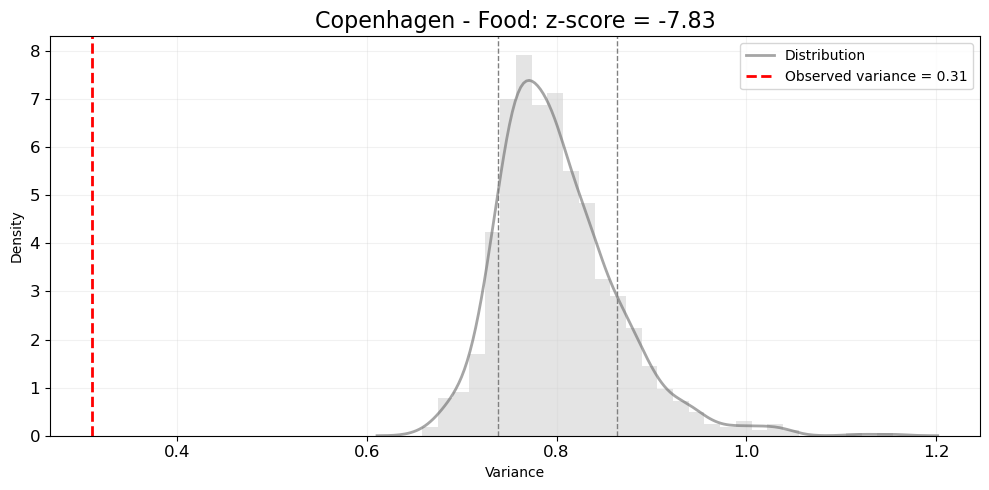

<Figure size 800x500 with 0 Axes>

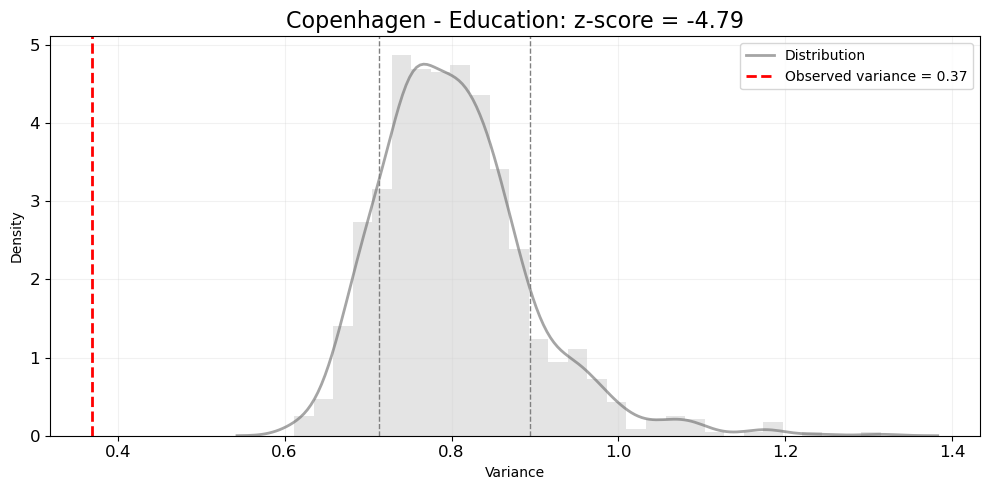

<Figure size 800x500 with 0 Axes>

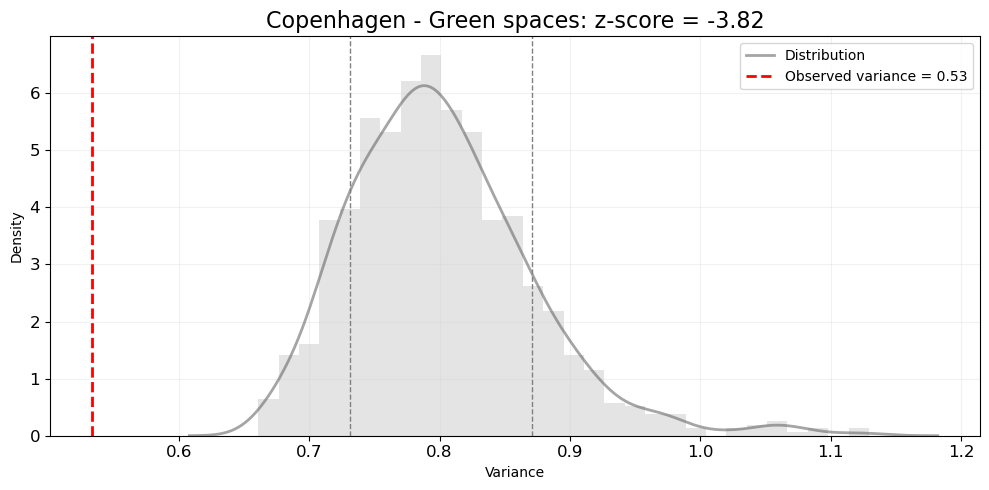

<Figure size 800x500 with 0 Axes>

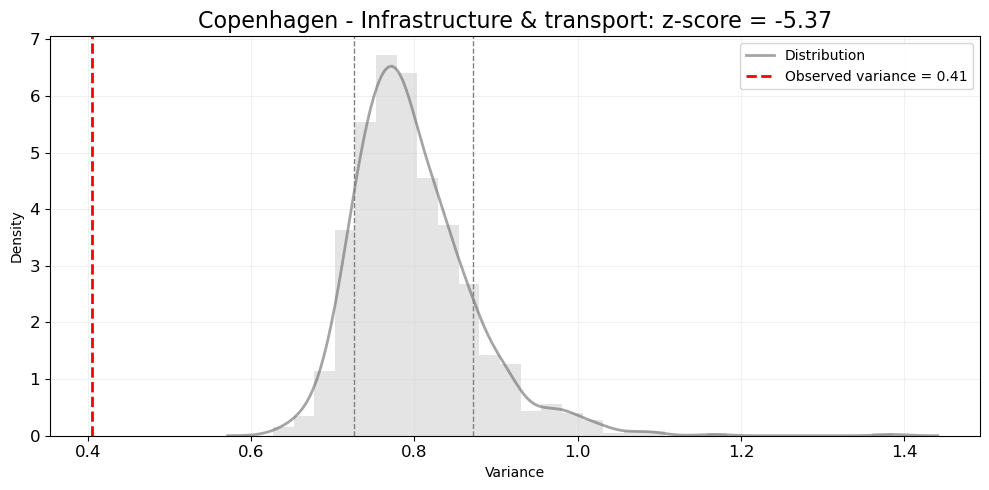

<Figure size 800x500 with 0 Axes>

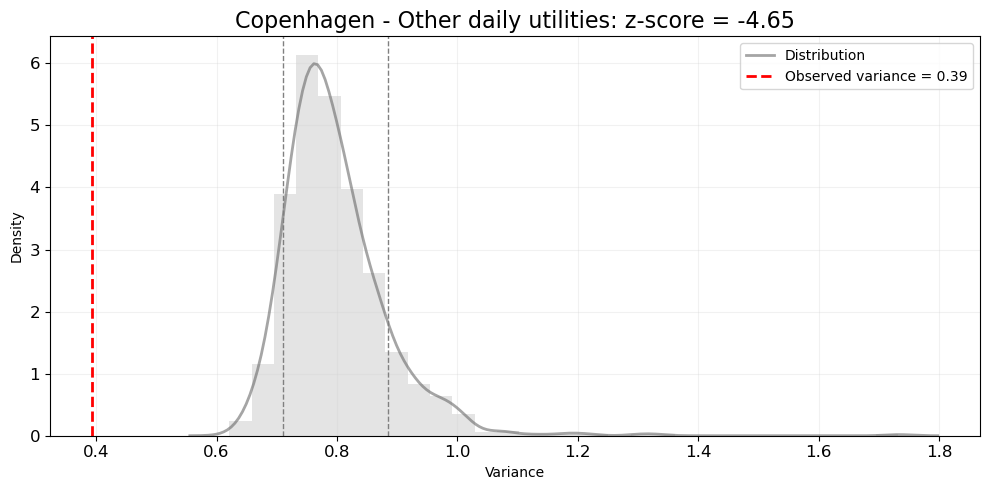

<Figure size 800x500 with 0 Axes>

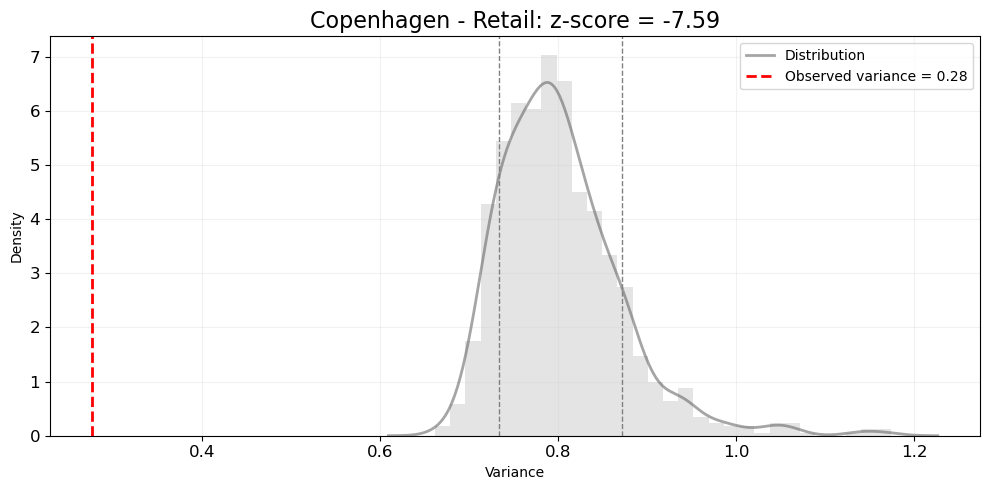

<Figure size 800x500 with 0 Axes>

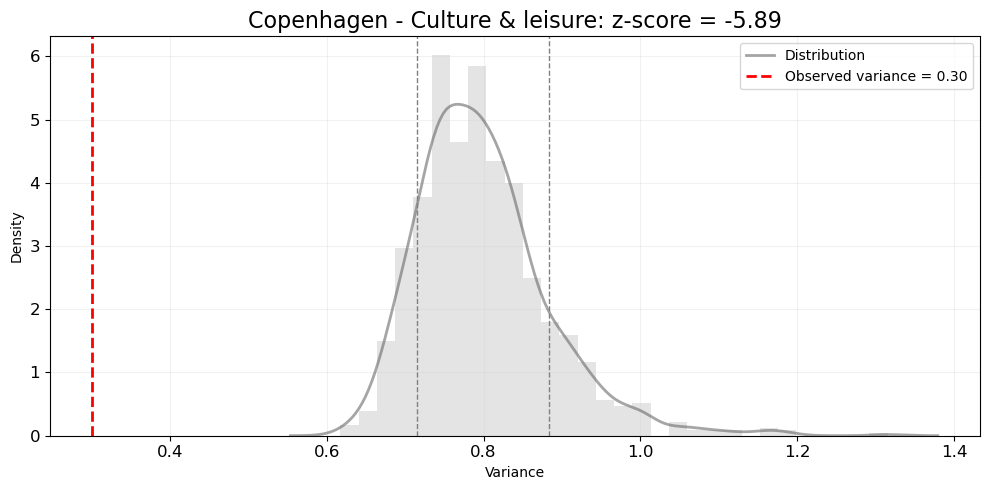

<Figure size 800x500 with 0 Axes>

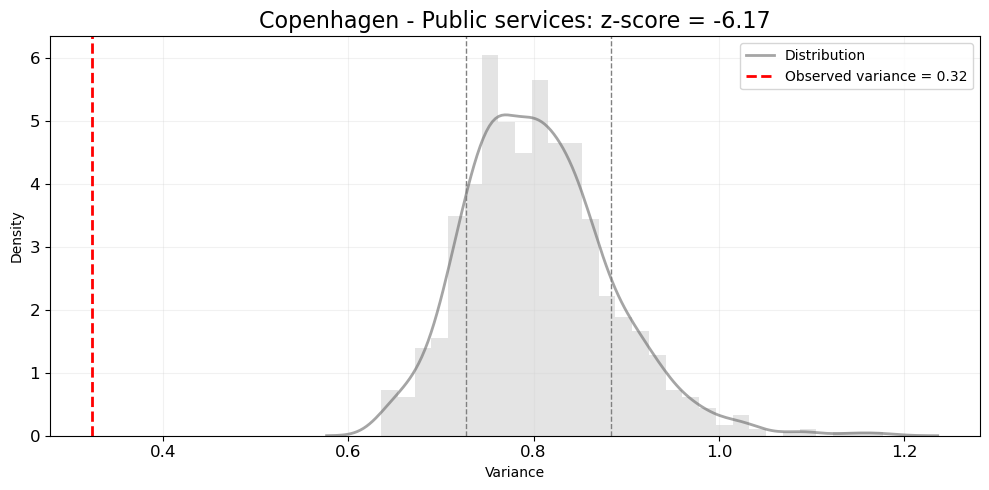

<Figure size 800x500 with 0 Axes>

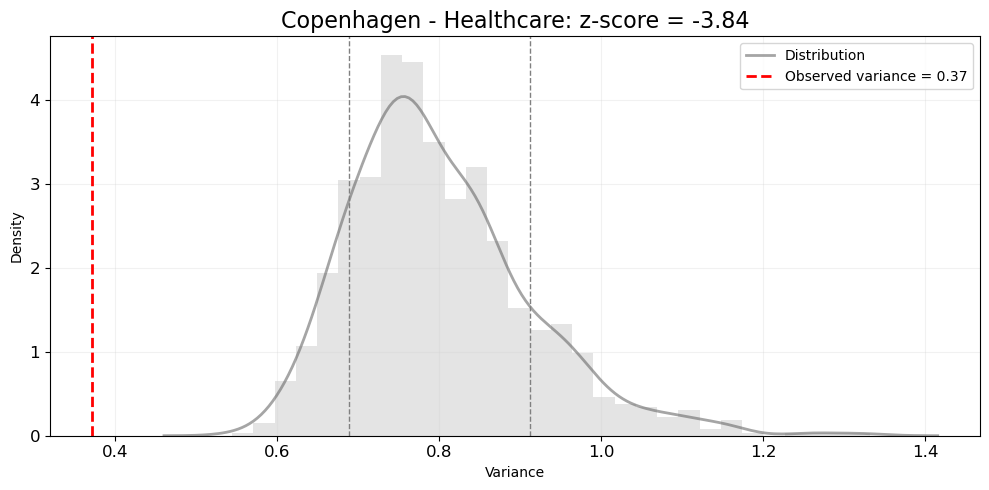

In [48]:
for category in df_z.index:
    plot_variance_distribution_from_results(category, df_z, label_map, CITY_NAME)

In [49]:
df_z

,real_var,mean_rand,std_rand,z_score,rand_vars
food,0.310291,0.800925,0.062638,-7.832813,"[0.7791979428415128, 0.7772705185814607, 0.799..."
education,0.369498,0.803777,0.090571,-4.794891,"[0.8195795496931835, 0.7040803773957035, 0.734..."
green_spaces,0.533707,0.801277,0.069984,-3.823311,"[0.8627088124827361, 0.8263462993790097, 0.715..."
infrastructure_transport,0.405366,0.798913,0.073267,-5.371375,"[0.8087171362366579, 0.7905827952291912, 0.825..."
other_daily_utilities,0.393534,0.797269,0.086736,-4.654741,"[0.7252662566084142, 0.7229660759594089, 0.730..."
retail,0.276325,0.802711,0.069329,-7.592606,"[0.8830255388326728, 0.8209153760040637, 0.702..."
culture_leisure,0.300649,0.799325,0.084647,-5.891230,"[0.7925916111134929, 0.7908214720227937, 0.732..."
public_services,0.323928,0.805153,0.077967,-6.172146,"[0.7568134345848841, 0.6736397970303877, 0.810..."
healthcare,0.371608,0.800134,0.111627,-3.838917,"[0.8540110200078933, 0.7760438776614462, 0.707..."


<Figure size 1000x600 with 0 Axes>

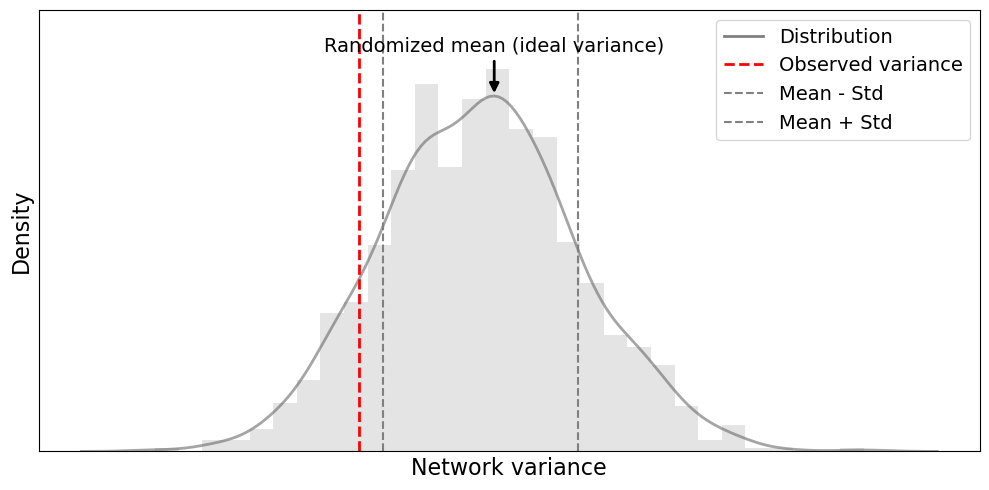

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

plt.rcParams['axes.labelsize'] = 16       # axis labels
plt.rcParams['legend.fontsize'] = 14


# ---------- 1. Generate conceptual (fake) random variance distribution ----------
np.random.seed(42)

rand_vars = np.random.normal(loc=5.0, scale=1.0, size=1000)
real_var = 3.8   # observed variance

mean_rand = np.mean(rand_vars)
std_rand = np.std(rand_vars)

# ---------- 2. First plot KDE to extract peak ----------
plt.figure(figsize=(10, 6))
kdeplot = sns.kdeplot(rand_vars, bw_adjust=1, color="black")
x_vals = kdeplot.get_lines()[0].get_xdata()
y_vals = kdeplot.get_lines()[0].get_ydata()
plt.clf()

# KDE peak
x_peak = x_vals[np.argmax(y_vals)]
y_peak = max(y_vals)

# ---------- 3. Main plot ----------
plt.figure(figsize=(10, 5))

# Histogram (light grey)
sns.histplot(
    rand_vars,
    bins=30,
    stat='density',
    color="lightgray",
    edgecolor=None,
    alpha = 0.6
)

# KDE curve (dark grey)
sns.kdeplot(
    rand_vars,
    bw_adjust=1,
    color="dimgray",
    linewidth=2,
    alpha = 0.6
)


plt.axvline(real_var, color="red", linestyle="--", linewidth=2,
            label="Observed variance")
plt.axvline(mean_rand - std_rand, color="gray", linestyle="--",
            label="Mean - Std")
plt.axvline(mean_rand + std_rand, color="gray", linestyle="--",
            label="Mean + Std")

# ---- Expand y-axis so arrow + label fit inside ----
ylim = plt.ylim()
plt.ylim(ylim[0], ylim[1] * 1.1)

plt.annotate(
    "Randomized mean (ideal variance)",
    xy=(x_peak, y_peak),
    xytext=(x_peak, y_peak + 0.05),
    ha='center',
    fontsize=14,  
    arrowprops=dict(arrowstyle='-|>', color="black", lw=2)
)

plt.xlabel("Network variance")
plt.ylabel("Density")
plt.grid(True, which='both', color="lightgray", alpha=0.3)
plt.xticks([])
plt.yticks([])

# -------- Add KDE to legend --------
kde_handle = Line2D([], [], color="gray", linewidth=2, label="Distribution")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=[kde_handle] + handles)

plt.tight_layout()

# ---- Save as PDF ----
plt.savefig("variance_plot.pdf", format="pdf", bbox_inches="tight")


plt.show()


Livability score

In [51]:
# Check the list of z-scores and rhe rows of GE matrix are consistens
print("Categories in GE:", df_ge.index.tolist())
print("Categories in z:", df_z.index.tolist())

Categories in GE: ['food', 'education', 'green_spaces', 'infrastructure_transport', 'other_daily_utilities', 'retail', 'culture_leisure', 'public_services', 'healthcare']
Categories in z: ['food', 'education', 'green_spaces', 'infrastructure_transport', 'other_daily_utilities', 'retail', 'culture_leisure', 'public_services', 'healthcare']


In [52]:
# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned = df_z.reindex(df_ge.index)

# Save z-scores
z_scores = df_z_aligned["z_score"].values

In [53]:
# Check if it worked, if the z-scores match
for cat, z in zip(df_ge.index, z_scores):
    print(f"{cat}: {z}")

food: -7.8328133142660255
education: -4.794890605451254
green_spaces: -3.8233110242928627
infrastructure_transport: -5.37137535883808
other_daily_utilities: -4.654740507951054
retail: -7.592606449630766
culture_leisure: -5.891229657441713
public_services: -6.1721464364517855
healthcare: -3.838917497560104


In [54]:
df_ge.head()

,food,education,green_spaces,infrastructure_transport,other_daily_utilities,retail,culture_leisure,public_services,healthcare
food,0.000000,0.100808,0.138264,0.087335,0.076061,0.046918,0.038358,0.069543,0.093242
education,0.100808,0.000000,0.077819,0.080655,0.077518,0.087518,0.104606,0.067135,0.061717
green_spaces,0.138264,0.077819,0.000000,0.122702,0.123640,0.128398,0.145284,0.108756,0.083081
infrastructure_transport,0.087335,0.080655,0.122702,0.000000,0.065287,0.077933,0.086882,0.071565,0.087835
other_daily_utilities,0.076061,0.077518,0.123640,0.065287,0.000000,0.068101,0.076663,0.059587,0.076972


In [55]:
# First livability score. 
def compute_livability_from_matrix(df_ge, z_scores):
    # Take ge matrix
    GE = df_ge.values
    # Convert z-scores into array and take absolute values
    z = np.abs(np.array(z_scores, dtype=float))
    # Change the shape of z to column vector and muptiply by ge
    scaled = z[:, None] * GE
    # Sum values
    total = scaled.sum()
    # Invert 
    return 1 / total if total != 0 else np.nan


In [56]:
# Livabiity score for the city
livability = compute_livability_from_matrix(df_ge, z_scores)
print("Livability score:", livability)

Livability score: 0.030444291546341776


Normalization 1 - use the average instead of the sum

In [57]:
# Livability score
def compute_livability_normalized_1(df_ge, z_scores):
    # Take ge matrix
    GE = df_ge.values

    # Convert z-scores into array and take absolute values
    z = np.abs(np.array(z_scores, dtype=float))

    # Change the shape of z to column vector and muptiply by ge
    scaled = z[:, None] * GE

    # Number of categories
    n=len(z)

    # Sum values
    sum = scaled.sum()

    # Average 
    average = sum/(n*(n-1))

    # Invert 
    return 1 / average if average != 0 else np.nan

In [58]:
# Livabiity score for the city
livability_normalized1 = compute_livability_normalized_1(df_ge, z_scores)
print("Livability score (with using average instead of sum):", livability_normalized1)

Livability score (with using average instead of sum): 2.1919889913366077


Normalization 2 - add weights to the edges in graph

In [59]:
list(G_largest.edges(data=True))[:20]

[(3, 11, {}),
 (3, 6, {}),
 (3, 12, {}),
 (3, 10, {}),
 (6, 11, {}),
 (6, 12, {}),
 (7, 40, {}),
 (7, 14, {}),
 (7, 10, {}),
 (7, 55, {}),
 (7, 9, {}),
 (7, 22, {}),
 (7, 49, {}),
 (7, 52, {}),
 (7, 51, {}),
 (7, 18, {}),
 (7, 43, {}),
 (7, 53, {}),
 (7, 67, {}),
 (7, 26, {})]

In [60]:
# Method for adding weigths to edges
def add_inv_degree_weights(G):
    deg = dict(G.degree())
    for u, v in G.edges():
        w = 0.5 * (1.0 / max(deg[u], 1) + 1.0 / max(deg[v], 1))
        G[u][v]["weight"] = float(w)
    return G

In [61]:
# Make a weighted copy of the graph
G_weighted = G_largest.copy()

# Add degree-based weights
G_weighted = add_inv_degree_weights(G_weighted)

# Recompute Q and GE matrix using the weighted graph
Q_weighted = compute_and_store_Q(G_weighted, CITY_NAME)

# Prepare category dictionaries
category_dicts_largest_weighted = prepare_category_dicts(category_counts, G_weighted)

# Compute GE matrix
df_ge_weighted = compute_generalized_euclidean_matrix(
    G_weighted, category_dicts_largest_weighted, ge=ge, Q_func=lambda G: Q_weighted
)

resistance_matrix_weighted = precompute_resistance(G_weighted)

# Compute variance for each category (using precomputed resistance matrix)
variance_categories_weighted = compute_variance(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted)

# Compute z-scores
df_z_weighted = compute_z_scores(category_dicts_largest_weighted, G_weighted, resistance_matrix_weighted, n_iter=1000)

# Align df_z to the same order as df_ge. So they correspond exactly
df_z_aligned_weighted = df_z_weighted.reindex(df_ge_weighted.index)

# Save z-scores
z_scores_weighted = df_z_aligned_weighted["z_score"].values

                           variance
food                      17.540116
education                 20.543961
green_spaces              25.445191
infrastructure_transport  20.607694
other_daily_utilities     20.091316
retail                    16.390457
culture_leisure           16.532699
public_services           17.923827
healthcare                21.407314


In [62]:
print(df_ge.compare(df_ge_weighted))

                              food           education           green_spaces  \
                              self     other      self     other         self   
food                           NaN       NaN  0.100808  0.293667     0.138264   
education                 0.100808  0.293667       NaN       NaN     0.077819   
green_spaces              0.138264  0.403493  0.077819  0.222711          NaN   
infrastructure_transport  0.087335  0.253531  0.080655  0.233510     0.122702   
other_daily_utilities     0.076061  0.220407  0.077518  0.221612     0.123640   
retail                    0.046918  0.135896  0.087518  0.254342     0.128398   
culture_leisure           0.038358  0.106354  0.104606  0.304928     0.145284   
public_services           0.069543  0.200387  0.067135  0.191424     0.108756   
healthcare                0.093242  0.270699  0.061717  0.171695     0.083081   

                                   infrastructure_transport            \
                             other 

In [63]:
# Compute livability score
livability_normalized2 = compute_livability_from_matrix(df_ge_weighted, z_scores_weighted)

print("Livability with weighted edges:", livability_normalized2)

Livability with weighted edges: 0.007144685906295884


Normalization 3 - normalizing generalized euclidean

In [64]:
# Normalize GE matrix so that all values sum to 1 - global 
def normalize_ge_sum_to_one(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)             # ensure diagonal = 0
    s = GE.sum()                          # total sum of all distances
    if s > 0:
        GE = GE / s                       # divide all by total sum
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_sum1 = normalize_ge_sum_to_one(df_ge)

In [65]:
print("Sum of GE before:", df_ge.values.sum())
print("Sum of GE after :", df_ge_sum1.values.sum())

Sum of GE before: 6.027014365410963
Sum of GE after : 1.0


In [66]:
# Compute livability again using normalized GE
livability_normalized3 = compute_livability_from_matrix(df_ge_sum1, z_scores)
print("Livability score (with normalized GE):", livability_normalized3)

Livability score (with normalized GE): 0.18348818249456142


In [67]:
# Row normalization; per category. Every row sum up to 1
def normalize_ge_rowwise(df_ge):
    GE = df_ge.values.astype(float).copy()
    np.fill_diagonal(GE, 0.0)
    row_sums = GE.sum(axis=1, keepdims=True)
    # avoid division by zero
    GE = np.divide(GE, row_sums, where=row_sums!=0)
    return pd.DataFrame(GE, index=df_ge.index, columns=df_ge.columns)

df_ge_row = normalize_ge_rowwise(df_ge)

In [68]:
livability_rowwise = compute_livability_from_matrix(df_ge_row, z_scores)
print("Livability score (row-normalized GE):", livability_rowwise)

Livability score (row-normalized GE): 0.020011193920935196


Normalization 4 - Logarithm of ge

In [69]:
# Copy GE matrix
GE = df_ge.values.astype(float)

# Replace zeros to avoid log(0)
GE[GE <= 0] = 1e-9

# Apply logarithm
GE_log = np.log(GE)

# Create DataFrame again
df_ge_log = pd.DataFrame(GE_log, index=df_ge.index, columns=df_ge.columns)

In [70]:
# Compute livability again
livability_log = compute_livability_from_matrix(df_ge_log, z_scores)
print("Livability (log-transformed GE):", livability_log)

Livability (log-transformed GE): -0.000487168184400595


Testing the logic of the formula

In [71]:
# Test a livability computation function across multiple edge cases
# livability_func must take (z, GE) as inputs and return a numeric score.

def test_livability_method(livability_func):

    # Base example
    z = np.array([-11, -7, -5])
    GE = np.array([[0,1,2],[1,0,3],[2,3,0]])
    base = livability_func(z, GE)

    # Larger city (distances x10)
    large = livability_func(z, GE * 10)

    # Smaller city (distances /10)
    small = livability_func(z, GE * 0.1)

    # More POIs within the same category
    GE_more_pois = GE * 0.9  # smaller = denser categories
    many = livability_func(z, GE_more_pois)

    # All z = 0
    z_balanced = np.zeros_like(z)
    balanced = livability_func(z_balanced, GE)

    # No POIs
    empty = livability_func([], np.zeros((0,0)))

    print("Base city:", base)
    print("Larger city (distances bigger):", large)
    print("Smaller city (distances smaller):", small)
    print("More POIs:", many)
    print("All z=0 (perfect balance):", balanced)
    print("No POIs:", empty)


In [72]:
def livability_unnormalized(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Unnormalized:")
test_livability_method(livability_unnormalized)

Unnormalized:
Base city: 0.011627906976608978
Larger city (distances bigger): 0.0011627906976730666
Smaller city (distances smaller): 0.11627906975392102
More POIs: 0.012919896640659949
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [73]:
def livability_average(z, GE):
    if len(z) < 2:
        return np.nan
    z = np.abs(z)
    n = len(z)
    total = (z[:, None] * GE).sum() / (n * (n - 1))
    return 1 / (total + 1e-9)


print("Normalization 1:")
test_livability_method(livability_average)

Normalization 1:
Base city: 0.06976744185559762
Larger city (distances bigger): 0.006976744185997837
Smaller city (distances smaller): 0.6976744181179014
More POIs: 0.07751937983895198
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [74]:
# The whole ge matrix sum to one
def livability_sum1(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    np.fill_diagonal(GE, 0)
    s = GE.sum()
    if s > 0:
        GE = GE / s
    return 1 / ((z[:, None] * GE).sum() + 1e-9)

print("Normalization 3:")
test_livability_method(livability_sum1)

Normalization 3:
Base city: 0.13953488370146025
Larger city (distances bigger): 0.13953488370146025
Smaller city (distances smaller): 0.13953488370146025
More POIs: 0.13953488370146025
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [75]:
# Row normalization: each category's distances sum to 1
def livability_row_normalized(z, GE):
    if len(z) == 0:
        return np.nan

    z = np.abs(z)
    GE = GE.astype(float).copy()

    row_sums = GE.sum(axis=1, keepdims=True)
    GE = np.divide(GE, row_sums, where=row_sums != 0)
    np.fill_diagonal(GE, 0.0)

    total = (z[:, None] * GE).sum()
    return 1 / (total + 1e-9)

print("Normalization 3:")
test_livability_method(livability_row_normalized)

Normalization 3:
Base city: 0.04347826086767486
Larger city (distances bigger): 0.04347826086767486
Smaller city (distances smaller): 0.04347826086767486
More POIs: 0.04347826086767486
All z=0 (perfect balance): 999999999.9999999
No POIs: nan


In [76]:
def livability_log(z, GE):
    if len(z) == 0:
        return np.nan
    z = np.abs(z)
    GE = GE.astype(float).copy()
    GE[GE <= 0] = 1e-9
    GE = np.log(GE)
    return 1 / ((z[:, None] * GE).sum() + 1e-9)


print("Normalization 4:")
test_livability_method(livability_log)

Normalization 4:
Base city: -0.002210621803060352
Larger city (distances bigger): -0.0028864819035638316
Smaller city (distances smaller): -0.0017912148308253184
More POIs: -0.002187188346635496
All z=0 (perfect balance): 999999999.9999999
No POIs: nan
